# Train Teacher Model (YOLOv11-L) for Knowledge Distillation
This step trains a high-capacity teacher model (YOLOv11-L) that will later be used to guide a smaller student model through Knowledge Distillation (KD). The teacher model should achieve strong feature representation and high mAP, because the quality of the distilled student model depends on how well the teacher has learned.

Key Goals:

- Achieve high mAP50 and mAP50-95

- Ensure the model converges fully (no early stop plateau)

- Produce a stable and generalizable checkpoint (best.pt) to be used for KD

Author by: mrbrownnn

In [ ]:
!nvidia-smi
!pip install ultralytics==8.3.0
!pip install roboflow
!pip install ultralytics==8.3.0 matplotlib seaborn
!nvidia-smi
import matplotlib.pyplot as plt
import seaborn as sns

# prepare model

Sat Nov 29 18:38:43 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   31C    P0             42W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
^C


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Derection dataset_folder

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

DATASET_DIR = "/content/drive/MyDrive/yolo_mtid_motor"
PROJECT_DIR = "/content/drive/MyDrive/yolo_traffic_teacher_v11_new-dataset_v3"

!mkdir -p {PROJECT_DIR}
%cd {PROJECT_DIR}


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/yolo_traffic_teacher_v11_new-dataset_v3


In [ ]:
from ultralytics import YOLO
# Load model YOLOv11 large
model = YOLO('yolo11l.pt')
model.info()
model = YOLO('yolo11l.pt')
#training func
results = model.train(
    data=f"{DATASET_DIR}/data.yaml",
    epochs=70,
    imgsz=640,
    batch=16,
    device=0,
    workers=2,
    cache=True,
    amp=True,
    cos_lr=True,
    patience=10,
    project=PROJECT_DIR,
    name="yolo11l_motor_teacher_v3"
)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
YOLO11l summary: 357 layers, 25,372,160 parameters, 0 gradients, 87.6 GFLOPs
New https://pypi.org/project/ultralytics/8.3.229 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.213 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/content/drive/MyDrive/yolo_mtid_motor/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, ep

In [ ]:
#recover version when disconnected to runtime
from ultralytics import YOLO
model = YOLO('/content/drive/MyDrive/yolo_traffic_teacher_v11_new-dataset_v3/yolo11l_motor_teacher_v32/weights/last.pt')
model.train(resume=True)


#hyperparameters
albumentations:
Blur(p=0.01, blur_limit=(3, 7)),
MedianBlur(p=0.01, blur_limit=(3, 7)),
ToGray(p=0.01, method='weighted_average', num_output_channels=3),
CLAHE(p=0.01,
clip_limit=(1.0, 4.0),
tile_grid_size=(8, 8))
momentum =0.9
lr =0.001111
batch =16

#Augment dataset func
  Teacher ratio: [1.0, 1.8, 1.5, 1.2, 2.0]
  Student after prun & quantized: [1.0, 2.0, 1.5, 1.2, (2.7-3.0)]

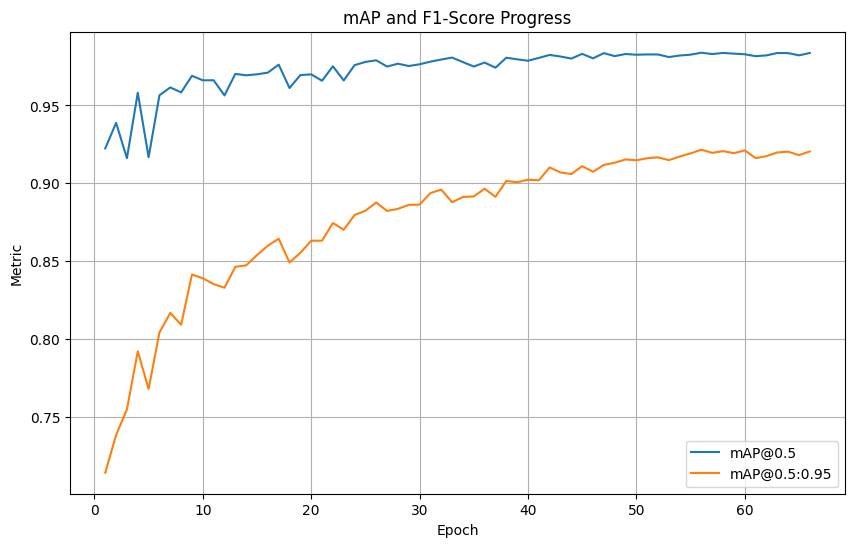

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import os

# Construct the path to the results.csv file
results_path = os.path.join(PROJECT_DIR, "yolo11l_motor_teacher_v32", "results.csv")

# Read the results.csv file into a pandas DataFrame
df = pd.read_csv(results_path)

plt.figure(figsize=(10,6))
plt.plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP@0.5')
plt.plot(df['epoch'], df['metrics/mAP50-95(B)'], label='mAP@0.5:0.95')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.title('mAP and F1-Score Progress')
plt.legend()
plt.grid(True)
plt.show()

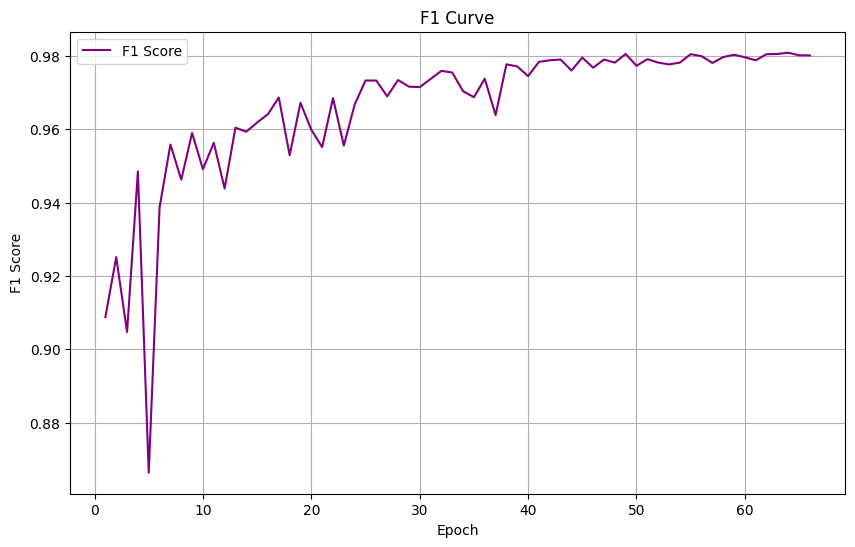

In [ ]:

plt.figure(figsize=(10,6))
f1 = 2 * (df['metrics/precision(B)'] * df['metrics/recall(B)']) / (df['metrics/precision(B)'] + df['metrics/recall(B)'])
plt.plot(df['epoch'], f1, label='F1 Score', color='purple')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('F1 Curve')
plt.legend()
plt.grid(True)
plt.show()


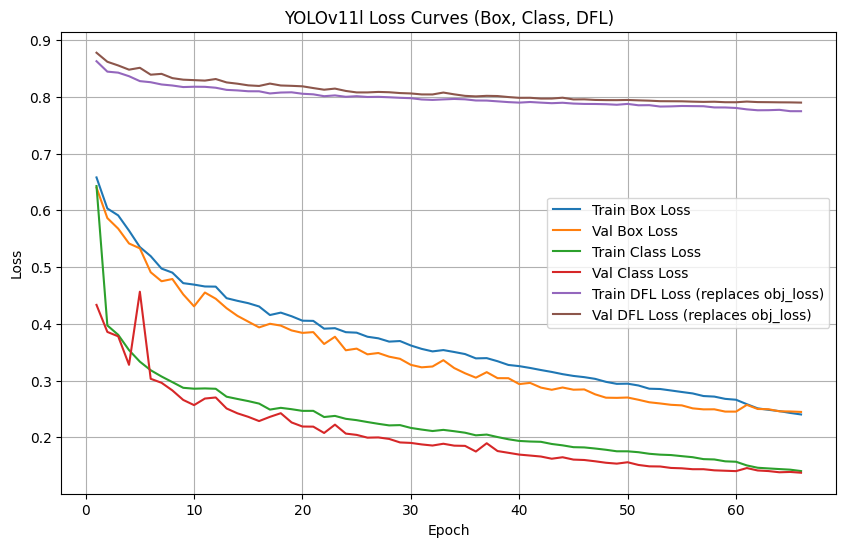

In [ ]:

plt.figure(figsize=(10,6))
plt.plot(df['epoch'], df['train/box_loss'], label='Train Box Loss')
plt.plot(df['epoch'], df['val/box_loss'], label='Val Box Loss')

plt.plot(df['epoch'], df['train/cls_loss'], label='Train Class Loss')
plt.plot(df['epoch'], df['val/cls_loss'], label='Val Class Loss')

plt.plot(df['epoch'], df['train/dfl_loss'], label='Train DFL Loss (replaces obj_loss)')
plt.plot(df['epoch'], df['val/dfl_loss'], label='Val DFL Loss (replaces obj_loss)')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('YOLOv11l Loss Curves (Box, Class, DFL)')
plt.legend()
plt.grid(True)
plt.show()



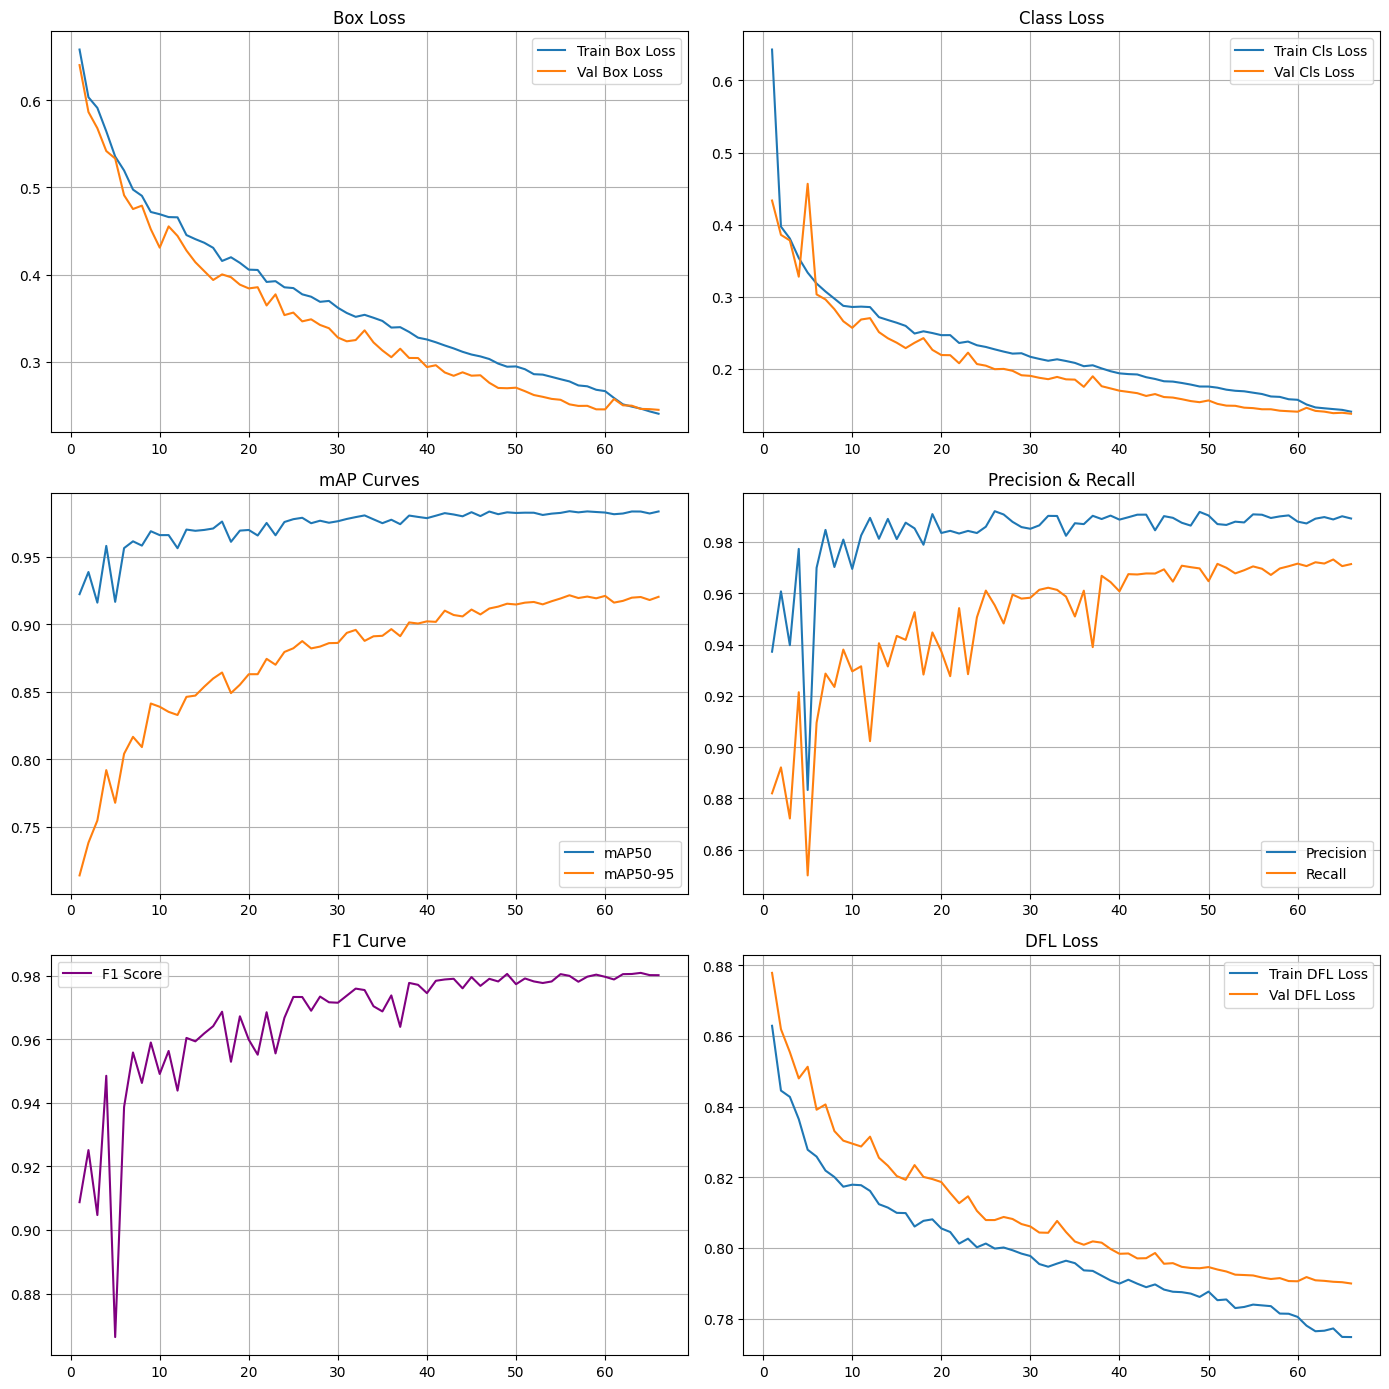

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(14, 14))

axes[0,0].plot(df['epoch'], df['train/box_loss'], label='Train Box Loss')
axes[0,0].plot(df['epoch'], df['val/box_loss'], label='Val Box Loss')
axes[0,0].set_title('Box Loss'); axes[0,0].legend(); axes[0,0].grid()

axes[0,1].plot(df['epoch'], df['train/cls_loss'], label='Train Cls Loss')
axes[0,1].plot(df['epoch'], df['val/cls_loss'], label='Val Cls Loss')
axes[0,1].set_title('Class Loss'); axes[0,1].legend(); axes[0,1].grid()

axes[1,0].plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP50')
axes[1,0].plot(df['epoch'], df['metrics/mAP50-95(B)'], label='mAP50-95')
axes[1,0].set_title('mAP Curves'); axes[1,0].legend(); axes[1,0].grid()

axes[1,1].plot(df['epoch'], df['metrics/precision(B)'], label='Precision')
axes[1,1].plot(df['epoch'], df['metrics/recall(B)'], label='Recall')
axes[1,1].set_title('Precision & Recall'); axes[1,1].legend(); axes[1,1].grid()

f1 = 2 * (df['metrics/precision(B)'] * df['metrics/recall(B)']) / (df['metrics/precision(B)'] + df['metrics/recall(B)'])
axes[2,0].plot(df['epoch'], f1, label='F1 Score', color='purple')
axes[2,0].set_title('F1 Curve'); axes[2,0].legend(); axes[2,0].grid()

axes[2,1].plot(df['epoch'], df['train/dfl_loss'], label='Train DFL Loss')
axes[2,1].plot(df['epoch'], df['val/dfl_loss'], label='Val DFL Loss')
axes[2,1].set_title('DFL Loss'); axes[2,1].legend(); axes[2,1].grid()


plt.tight_layout()
plt.show()

#Knowledge Distillation Function

In [ ]:
!pip install -U ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 66.6 MB/s eta 0:00:00
  Attempting uninstall: ultralytics
    Found existing installation: ultralytics 8.3.0
    Uninstalling ultralytics-8.3.0:
      Successfully uninstalled ultralytics-8.3.0


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from ultralytics import YOLO
from ultralytics.models.yolo.detect import DetectionTrainer
from ultralytics.utils import RANK


TEACHER_PATH = "/content/drive/MyDrive/yolo_traffic_teacher_v11_new-dataset_v3/yolo11l_motor_teacher_v32/weights/best.pt"
STUDENT_PATH = "/content/drive/MyDrive/yolo_customzied/yolo11n_pruned_finetune_phase22/weights/best.pt"
DATA_YAML = "/content/drive/MyDrive/data-merge/datamerge.yaml"
PROJECT = "/content/drive/MyDrive/yolo_kd_phase3"

KD_ALPHA = 0.5
KD_BETA = 0.3
KD_TEMPERATURE = 4.0
FREEZE_LAYERS = 10


class KDTrainer(DetectionTrainer):

    def __init__(self, teacher_model, kd_alpha, kd_beta, kd_temperature, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.teacher = teacher_model
        self.kd_alpha = kd_alpha
        self.kd_beta = kd_beta
        self.kd_temperature = kd_temperature

        self.teacher.eval()
        for param in self.teacher.parameters():
            param.requires_grad = False

    def get_model(self, cfg=None, weights=None, verbose=True):
        return super().get_model(cfg, weights, verbose)

    def criterion(self, preds, batch):
        loss_hard, loss_items = super().criterion(preds, batch)

        with torch.no_grad():
            teacher_preds = self.teacher(batch['img'])

        loss_feature = self._compute_feature_distillation(preds, teacher_preds)
        loss_logit = self._compute_logit_distillation(preds, teacher_preds)

        total_loss = (1 - self.kd_alpha - self.kd_beta) * loss_hard + \
                     self.kd_alpha * loss_feature + \
                     self.kd_beta * loss_logit

        return total_loss, loss_items

    def _compute_feature_distillation(self, student_preds, teacher_preds):
        if len(student_preds) < 2 or len(teacher_preds) < 2:
            return torch.tensor(0.0, device=student_preds[0].device)

        student_features = student_preds[1] if isinstance(student_preds[1], (list, tuple)) else [student_preds[1]]
        teacher_features = teacher_preds[1] if isinstance(teacher_preds[1], (list, tuple)) else [teacher_preds[1]]

        loss = 0.0
        count = 0

        for s_feat, t_feat in zip(student_features, teacher_features):
            if s_feat.shape != t_feat.shape:
                continue

            s_norm = F.normalize(s_feat.flatten(2), dim=1)
            t_norm = F.normalize(t_feat.flatten(2), dim=1)

            loss += F.mse_loss(s_norm, t_norm)
            count += 1

        return loss / count if count > 0 else torch.tensor(0.0, device=student_preds[0].device)

    def _compute_logit_distillation(self, student_preds, teacher_preds):
        student_output = student_preds[0]
        teacher_output = teacher_preds[0]

        if not isinstance(student_output, torch.Tensor) or not isinstance(teacher_output, torch.Tensor):
            return torch.tensor(0.0, device=student_preds[0].device if isinstance(student_preds[0], torch.Tensor) else 'cpu')

        if student_output.shape != teacher_output.shape:
            return torch.tensor(0.0, device=student_output.device)

        T = self.kd_temperature

        student_soft = F.log_softmax(student_output / T, dim=-1)
        teacher_soft = F.softmax(teacher_output / T, dim=-1)

        loss = F.kl_div(student_soft, teacher_soft, reduction='batchmean') * (T * T)

        return loss


def create_kd_trainer(teacher_model, kd_alpha, kd_beta, kd_temperature):
    class CustomKDTrainer(KDTrainer):
        def __init__(self, *args, **kwargs):
            super().__init__(
                teacher_model=teacher_model,
                kd_alpha=kd_alpha,
                kd_beta=kd_beta,
                kd_temperature=kd_temperature,
                *args,
                **kwargs
            )
    return CustomKDTrainer


def freeze_backbone(model, num_layers=10):
    frozen_count = 0
    for i, (name, module) in enumerate(model.model.named_modules()):
        if i >= num_layers:
            break
        if isinstance(module, nn.Module) and hasattr(module, 'parameters'):
            for param in module.parameters():
                param.requires_grad = False
                frozen_count += 1

    return frozen_count


if __name__ == '__main__':
    print("Initializing Knowledge Distillation Training...")

    print("Loading teacher model...")
    teacher_model = YOLO(TEACHER_PATH).model
    teacher_model.eval()
    for param in teacher_model.parameters():
        param.requires_grad = False

    print("Loading student model...")
    student = YOLO(STUDENT_PATH)

    print(f"Freezing first {FREEZE_LAYERS} layers...")
    frozen_count = freeze_backbone(student.model, FREEZE_LAYERS)
    print(f"Frozen {frozen_count} parameters")

    print("Creating KD trainer...")
    trainer_class = create_kd_trainer(
        teacher_model=teacher_model,
        kd_alpha=KD_ALPHA,
        kd_beta=KD_BETA,
        kd_temperature=KD_TEMPERATURE
    )

    print("Starting training...")
    trainer = trainer_class(
        overrides={
            'model': STUDENT_PATH,
            'data': DATA_YAML,
            'epochs': 30,
            'imgsz': 640,
            'batch': 16,
            'project': PROJECT,
            'name': 'kd_phase3_optimized',
            'device': 0,
            'patience': 10,
            'save': True,
            'verbose': True
        }
    )

    trainer.train()

    print("Training completed!")
    print(f"Best model saved at: {trainer.save_dir}")

Initializing Knowledge Distillation Training...
Loading teacher model...
Loading student model...
Freezing first 10 layers...
Frozen 283 parameters
Creating KD trainer...
Starting training...
Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/data-merge/datamerge.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0

#quick compare mAP50 & mAP50-90 before/after disstilled

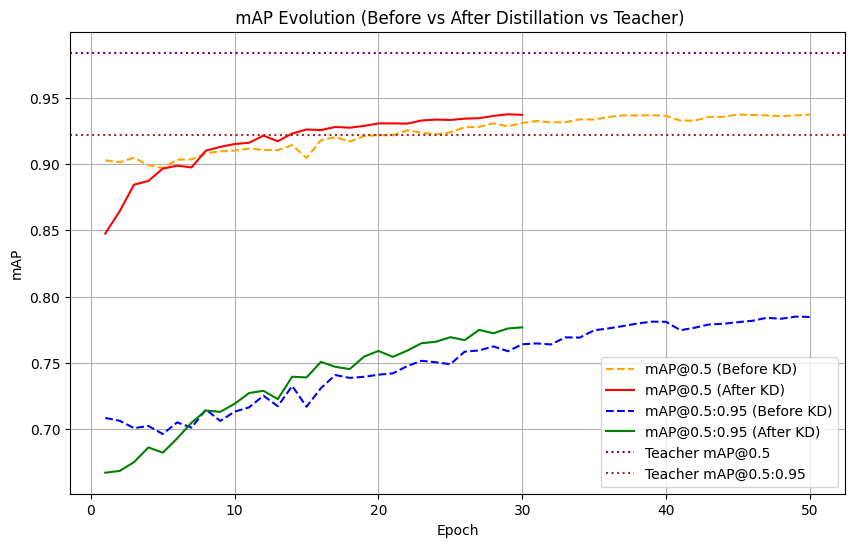

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# ==================== CONFIG ====================
before_path = "/content/drive/MyDrive/yolo_customzied/yolo11n_pruned_finetune_phase22/results.csv"
after_path  = "/content/drive/MyDrive/yolo_kd_phase3/kd_phase3_optimized/results.csv"
teacher_map50 = 0.984
teacher_map5095 = 0.922

# ==================== LOAD METRICS ====================
df_before = pd.read_csv(before_path)
df_after = pd.read_csv(after_path)
# find columns
def find_col(df, pattern):
    for c in df.columns:
        if pattern in c:
            return c
    raise KeyError(f"Column with pattern '{pattern}' not found")

mAP50_b = find_col(df_before, "mAP50")
mAP5095_b = find_col(df_before, "mAP50-95")
mAP50_a = find_col(df_after, "mAP50")
mAP5095_a = find_col(df_after, "mAP50-95")

# ==================== PLOT MAP CURVES ====================
plt.figure(figsize=(10,6))
plt.plot(df_before['epoch'], df_before[mAP50_b], label='mAP@0.5 (Before KD)', linestyle='--', color='orange')
plt.plot(df_after['epoch'], df_after[mAP50_a], label='mAP@0.5 (After KD)', linestyle='-', color='red')
plt.plot(df_before['epoch'], df_before[mAP5095_b], label='mAP@0.5:0.95 (Before KD)', linestyle='--', color='blue')
plt.plot(df_after['epoch'], df_after[mAP5095_a], label='mAP@0.5:0.95 (After KD)', linestyle='-', color='green')

#  teacher benchmark lines
plt.axhline(y=teacher_map50, color='purple', linestyle=':', label='Teacher mAP@0.5')
plt.axhline(y=teacher_map5095, color='brown', linestyle=':', label='Teacher mAP@0.5:0.95')
plt.xlabel("Epoch")
plt.ylabel("mAP")
plt.title(" mAP Evolution (Before vs After Distillation vs Teacher)")
plt.legend()
plt.grid(True)
plt.show()


#awareness quantization

#Quantization function

In [ ]:
!pip uninstall -y onnx onnx-graphsurgeon
!pip install onnx==1.16.1 onnx-graphsurgeon==0.5.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 86.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.4/56.4 kB 3.9 MB/s eta 0:00:00


In [ ]:
import onnx
import onnx_graphsurgeon
print(f"ONNX version: {onnx.__version__}")
print(f"ONNX-GraphSurgeon version: {onnx_graphsurgeon.__version__}")
print(f"Has float32_to_bfloat16: {hasattr(onnx.helper, 'float32_to_bfloat16')}")

ONNX version: 1.16.1
ONNX-GraphSurgeon version: 0.5.2
Has float32_to_bfloat16: True


In [ ]:
# ============================================================
# TFLITE INT8 EXPORT
# ============================================================
import os, random, shutil, glob, yaml
from ultralytics import YOLO

# ======================
# CONFIG
# ======================
STUDENT_WEIGHTS = "/content/drive/MyDrive/yolo_traffic_distill_v11n_customized_v2.0/yolo11n_ghost_distilled/weights/best.pt"
DATA_ROOT = "/content/drive/MyDrive/yolo_mtid_motor"
NUM_CALIB_IMAGES = 100
IMG_SIZE = 640

# ======================
# 1) Tạo mini-val
# ======================
print("[1] Creating mini calibration dataset...")

mini_root = "/content/mini_val"
os.makedirs(f"{mini_root}/images", exist_ok=True)
os.makedirs(f"{mini_root}/labels", exist_ok=True)

val_imgs = glob.glob(f"{DATA_ROOT}/images/val/*.jpg")
selected = random.sample(val_imgs, NUM_CALIB_IMAGES)

for img in selected:
    lbl = img.replace("images", "labels").replace(".jpg", ".txt")
    shutil.copy(img, f"{mini_root}/images/")
    shutil.copy(lbl, f"{mini_root}/labels/")

print(f"Copied {NUM_CALIB_IMAGES} images for INT8 calibration")

# ======================
# 2) Tạo mini_data.yaml
# ======================
print("[2] Writing mini_data.yaml...")

mini_yaml = "/content/mini_data.yaml"
data_yaml = {
    "train": f"{DATA_ROOT}/images/train",
    "val": f"{mini_root}/images",
    "nc": 5,
    "names": ["car", "bicycle", "bus", "truck", "motorbike"]
}

with open(mini_yaml, "w") as f:
    yaml.dump(data_yaml, f)

print("mini_data.yaml created")

# ======================
# 3) Export INT8 TFLite
# ======================
print("[3] Loading student model...")
model = YOLO(STUDENT_WEIGHTS)

print("[4] Exporting TFLite INT8 (fast mode)...")

export_dir = model.export(
    format="tflite",
    int8=True,
    data=mini_yaml,
    imgsz=IMG_SIZE,
    optimize=True,
    batch=1,
    dynamic=False,
    keras=False,
    project=os.path.dirname(STUDENT_WEIGHTS),
    name="tflite_int8_fast"
)

print("\n[DONE] INT8 model saved at:")
print(export_dir)


[1] Creating mini calibration dataset...
✔ Copied 100 images for INT8 calibration
[2] Writing mini_data.yaml...
mini_data.yaml created
[3] Loading student model...
[4] Exporting TFLite INT8 (fast mode)...
Ultralytics 8.3.213 🚀 Python-3.12.12 torch-2.8.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
YOLO11n summary (fused): 100 layers, 2,583,127 parameters, 0 gradients, 6.3 GFLOPs

PyTorch: starting from '/content/drive/MyDrive/yolo_traffic_distill_v11n_customized_v2.0/yolo11n_ghost_distilled/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 9, 8400) (5.2 MB)

TensorFlow SavedModel: starting export with tensorflow 2.19.0...
Unzipping calibration_image_sample_data_20x128x128x3_float32.npy.zip to /content/calibration_image_sample_data_20x128x128x3_float32.npy...: 100% ━━━━━━━━━━━━ 1/1 41.1files/s 0.0s

ONNX: starting export with onnx 1.16.1 opset 21...
ONNX: slimming with onnxslim 0.1.74...
ONNX: export success ✅ 2.9s, saved as '/content/drive/MyDrive/yolo_traffic_dis

In [ ]:
# ULTRALYTICS → TFLITE FP16 EXPORT
from ultralytics import YOLO
from pathlib import Path

# CONFIG
STUDENT_WEIGHTS = Path(
    "/content/drive/MyDrive/yolo_traffic_distill_v11n_customized_v2.0/"
    "yolo11n_ghost_distilled/weights/best.pt"
)
IMG_SIZE = 640

print("[1] Loading Student model…")
model = YOLO(str(STUDENT_WEIGHTS))

print("[2] Exporting → TFLite FP16 (no calibration, fast)…")

export_dir = model.export(
    format="tflite",
    half=True,       # FP16
    imgsz=IMG_SIZE,
    optimize=True,
    keras=False,
    dynamic=False,
    batch=1,
    project=str(STUDENT_WEIGHTS.parent),
    name="tflite_fp16"
)

print("\n[DONE] FP16 TFLite saved at:")
print(export_dir)


[1] Loading Student model…
[2] Exporting → TFLite FP16 (no calibration, fast)…
Ultralytics 8.3.213 🚀 Python-3.12.12 torch-2.8.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
YOLO11n summary (fused): 100 layers, 2,583,127 parameters, 0 gradients, 6.3 GFLOPs

PyTorch: starting from '/content/drive/MyDrive/yolo_traffic_distill_v11n_customized_v2.0/yolo11n_ghost_distilled/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 9, 8400) (5.2 MB)

TensorFlow SavedModel: starting export with tensorflow 2.19.0...

ONNX: starting export with onnx 1.16.1 opset 21...
ONNX: slimming with onnxslim 0.1.74...
ONNX: export success ✅ 1.5s, saved as '/content/drive/MyDrive/yolo_traffic_distill_v11n_customized_v2.0/yolo11n_ghost_distilled/weights/best.onnx' (10.2 MB)
TensorFlow SavedModel: starting TFLite export with onnx2tf 1.28.3...
Saved artifact at '/content/drive/MyDrive/yolo_traffic_distill_v11n_customized_v2.0/yolo11n_ghost_distilled/weights/best_saved_model'. The following endpoint